# Create tables/figures for image experiments in ICLR submission
This notebook shows how to create the tables and figures for the image classification experiments in the ICRL paper. 

The SFR experiments were submitted with slurm using:
```sh
python train_and_inference.py -m ++wandb.use_wandb=True +experiment=cifar10_cnn,fmnist_cnn ++run_laplace_flag=False ++run_sfr_flag=True ++num_inducings='[3200]','[2048]','[1024]','[512]','[256]','[128]' ++random_seed=68,117,36,187,17 hydra/launcher=lumi_20hrs
```
and the Laplace baselines were submitted with:
```sh
python train_and_inference.py -m ++wandb.use_wandb=True +experiment=cifar10_cnn,fmnist_cnn ++run_laplace_flag=True ++run_sfr_flag=False ++random_seed=68,117,36,187,17 hydra/launcher=lumi_20hrs
```
Alternatively, a single job can be run with:
```sh
python train_and_inference.py ++wandb.use_wandb=True +experiment=cifar10_cnn ++run_laplace_flag=False ++run_sfr_flag=True ++num_inducings='[2048]' ++random_seed=68 hydra/launcher=lumi_20hrs
```
This avoids using hydra's sumbitit launcher plugin to submit jobs using slurm.

We report results (test. Accuracy, test. NLPD, test. ECE, AUROC) on Fashion-MNIST/CIFAR-10 for:
- Baselines
    - NN MAP
    - Laplace BNN/GLM with diag/kron Hessian structures both with/without prior precision $\delta$ tuning
    - GP predictive (Immer et al 2021) for M=3200 with/without prior precision $\delta$ tuning
- Ablation
    - SFR for M=128/256/512/1024/2048/3200 with/without prior precision $\delta$ tuning
    - GP subset for M=128/256/512/1024/2048/3200 with/without prior precision $\delta$ tuning

## Let's begin

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tikzplotlib
import wandb
from scipy.stats import ttest_ind

/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/3986974478.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load data

Either download the runs from W&B (and save as csv) or load data from a csv.

In [2]:
download_runs = False

In [3]:
WANDB_ENTITY = "aalto-ml"
WANDB_PROJECT = "sfr-experiments"

In [4]:
WANDB_RUNS_DICT = {
        "CIFAR10": [
            # M=3200
            "xk0yjr6t", # seed=117
            "krefuxhd", # seed=36
            "9jwp9ka4", # seed=17
            "pyaorowm", # seed=187
            "qxsde039", # seed=68 
            # M=2048
            "qwxe4q83", # seed=117
            "fus3naw0", # seed=36
            "iwoesck1", # seed=17
            "8o5trhzk", # seed=187
            "7elj653u", # seed=68 
            # M=1024
            "inbt4soc", # seed=117
            "qhtc5p34", # seed=36
            "gur15p02", # seed=17
            "x4ohx6up", # seed=187
            "fflzks3w", # seed=68 
            # M=512
            "4i9rdtuc", # seed=117
            "m9f6lr3o", # seed=36
            "j4a7z3rq", # seed=17
            "m006yp94", # seed=187
            "ogqe4w2r", # seed=68 
            # M=256
            "pm8vlxnv", # seed=117
            "zl0902i6", # seed=36
            "si29vthq", # seed=17
            "k61hcxdv", # seed=187
            "v9dku7av", # seed=68 
            # M=128
            "qr466eai", # seed=117
            "4zpds9aw", # seed=36
            "bd0nj9xm", # seed=17
            "6xb7i8xx", # seed=187
            "erugdppk", # seed=68 
            # Laplace
            "esuno76e", # seed=117
            "22x9f10u", # seed=36
            "vq4s6d5w", # seed=17
            "i6fitwmq", # seed=187
            "fvlz3fj5", # seed=68
        ],
        "FMNIST": [
            # M=3200
            "shig0trc", # seed=117
            "zz6og36d", # seed=36
            "e7wvqs1j", # seed=17
            "wu9ysdal", # seed=187
            "6v059ihw", # seed=68 
            # M=2048
            "qkhrxl30", # seed=117
            "6xloaqbq", # seed=36
            "dabpzj6q", # seed=17
            "1w5g55a6", # seed=187
            "56hcz5oy", # seed=68 
            # M=1024
            "demtnmqt", # seed=117
            "v3g1m7b8", # seed=36
            "r3qjawmi", # seed=17
            "01wb580x", # seed=187
            "bz5f869p", # seed=68 
            # M=512
            "et74ac1h", # seed=117
            "q8dojgzq", # seed=36
            "bxh7vaj1", # seed=17
            "58w1983y", # seed=187
            "7szmds5q", # seed=68 
            # M=256
            "8genclpc", # seed=117
            "8191tlal", # seed=36
            "d8zfol8v", # seed=17
            "uh9gh5od", # seed=187
            "mzd2t54t", # seed=68 
            # M=128
            "yrbc2i89", # seed=117
            "czuyh9r6", # seed=36
            "m9nme1yh", # seed=17
            "y86rcpxw", # seed=187
            "smmenbgn", # seed=68 
            # Laplace
            "mq5aqe5l", # seed=117
            "n077156c", # seed=36
            "a3wlndkr", # seed=17
            "e80xjz0d", # seed=187
            "vlgatx47", # seed=68
        ]
}
WANDB_RUNS = WANDB_RUNS_DICT["CIFAR10"] + WANDB_RUNS_DICT["FMNIST"]

In [5]:
def load_table_as_dataframe():
    api = wandb.Api(timeout=19)
    dfs = []
    for run_id in WANDB_RUNS:
        print("Getting data for seed with run_id: {}".format(run_id))
        table_artifact = api.artifact(f"{WANDB_ENTITY}/{WANDB_PROJECT}/run-{run_id}-Metrics:latest")
        table_artifact.download()
        table = table_artifact.get("Metrics")
        df = pd.DataFrame(data=table.data, columns=table.columns)
        dfs.append(df)
    df_all = pd.concat(dfs)
    return df_all

def save_wandb_runs_as_csv(save_path: str):
    df = load_table_as_dataframe()
    df.to_csv(save_path)
    return df

In [6]:
data_path = "./csv/image-experiments.csv"

if download_runs:
    df = save_wandb_runs_as_csv(data_path)
else:
    df = pd.read_csv(data_path)

## Helper functions

Let's create some helper functions

In [7]:
def bold_if_significant(row, metric, best_model_res, best_model, original_df):
    if row.equals(best_model):
        mean = "\mathbf{" + f"{row[metric]['mean']:.2f}" + "}"
        std = "\mathbf{" + f"{(row[metric]['std']):.2f}" + "}"
    else:
        mask_model = original_df['model'] == row['model'].iloc[0]
        mask_nind  = original_df['num_inducing'] == row['num_inducing'].iloc[0]
        selected_rows = original_df[mask_model & mask_nind]
        ttest_result = ttest_ind(best_model_res[metric], 
                                 selected_rows[metric])
        if ttest_result.pvalue < 0.05 or row["model"].iloc[0] in "\sc nn map": # don't bold map
            # reject the null hypothesis of identical avg NLPDs
            mean = f"{row[metric]['mean']:.2f}"
            std = f"{(row[metric]['std']):.2f}"
        else:
            mean = "\mathbf{" + f"{row[metric]['mean']:.2f}" + "}"
            std = "\mathbf{" + f"{(row[metric]['std']):.2f}" + "}"
    return "\\val{" + mean + "}{" + std + "}"


def bold_results(df_dataset, original_df, metrics = ['nlpd', 'acc', 'ece'], not_bold_map = True):
    for metric in metrics:
        print(f"metric: {metric}")
        if metric == "acc" or  metric == "ood_auc":
            sorted_idx = np.argsort(df_dataset[metric]['mean'].to_numpy())[::-1]
        else:
            sorted_idx = np.argsort(df_dataset[metric]['mean'].to_numpy())
        
        best_model = df_dataset.iloc[[sorted_idx[0]]]
        map = df_dataset[df_dataset["model"] == "\sc nn map"]
        idx = 0
        while best_model.equals(map) and not_bold_map:
            idx += 1
            best_idx = sorted_idx[idx] 
            best_model = df_dataset.iloc[[best_idx]]
        mask_model = original_df['model'] == best_model['model'].iloc[0]
        mask_nind  = original_df['num_inducing'] == best_model['num_inducing'].iloc[0]
        best_model_res = original_df[mask_model & mask_nind]
        print(f"best_model_res {best_model_res['model'].iloc[0]} with {best_model_res['num_inducing'].iloc[0]}")
        df_dataset[f"{metric}_mean_pm_std"] = df_dataset.apply(bold_if_significant, 
                                                               args=(metric, 
                                                                     best_model_res, 
                                                                     best_model,
                                                                     original_df), 
                                                               axis=1)
    df_dataset = df_dataset.reset_index()
    return df_dataset

## Create Table 1 - Image classification using CNN (without $\delta$ tuning)

We report results (test NLPD, test Accuracy, test AUROC) on Fashion-MNIST/CIFAR-10 for:
- Baselines
    - NN MAP
    - Laplace BNN with kron Hessian structures both without prior precision $\delta$ tuning
    - Laplace BNN with diag Hessian structures both without prior precision $\delta$ tuning
    - Laplace GLM with kron Hessian structures both without prior precision $\delta$ tuning
    - Laplace GLM with diag Hessian structures both without prior precision $\delta$ tuning
    - GP predictive (Immer et al 2021) for M=3200 without prior precision $\delta$ tuning
- Ablation
    - GP subset for M=2400 without prior precision $\delta$ tuning
    - GP subset for M=3200 without prior precision $\delta$ tuning
    - SFR for M=2400 without prior precision $\delta$ tuning
    - SFR for M=3200 without prior precision $\delta$ tuning

In [9]:
def create_table_1(df, print_latex: bool = False, save: bool = False):
    MODEL_LIST = [
        "NN MAP",
        "BNN diag",
        "GLM diag",
        "BNN kron",
        "GLM kron",
        "GP Subset (NN)", # GP predictive
        "GP Subset (GP)",
        "SFR (GP)",
    ]
    INDEX = [
        ('FMNIST',          '\sc nn map',    '-'),
        ('FMNIST',        '\sc laplace diag',    '-'),
        ('FMNIST',        '\sc laplace kron',    '-'),
        ('FMNIST',        '\sc laplace glm diag',    '-'),
        ('FMNIST',        '\sc laplace glm kron',    '-'),
        ('FMNIST', '\\rebuttal{\sc gp predictive}', 3200.0),
        ('FMNIST',     '{\sc gp subset}', 2048.0),
        ('FMNIST',     '{\sc gp subset}', 3200.0),
        ('FMNIST',                '\our (Ours)', 2048.0),
        ('FMNIST',                '\our (Ours)', 3200.0),
        ('CIFAR10',          '\sc nn map',    '-'),
        ('CIFAR10',        '\sc laplace diag',    '-'),
        ('CIFAR10',        '\sc laplace kron',    '-'),
        ('CIFAR10',        '\sc laplace glm diag',    '-'),
        ('CIFAR10',        '\sc laplace glm kron',    '-'),
        ('CIFAR10', '\\rebuttal{\sc gp predictive}', 3200.0),
        ('CIFAR10',     '{\sc gp subset}', 2048.0),
        ('CIFAR10',     '{\sc gp subset}', 3200.0),
        ('CIFAR10',                '\our (Ours)', 2048.0),
        ('CIFAR10',                '\our (Ours)', 3200.0),
    ]
    # Only keeps models we want in table
    df_table = df[df["model"].isin(MODEL_LIST)]

    # Make model names nice for latex with small caps
    COLUMNS_TITLES_DICT = {
        "NN MAP": "\sc nn map",
        "BNN diag": "\sc laplace diag",
        "GLM diag": "\sc laplace glm diag",
        "BNN kron": "\sc laplace kron",
        "GLM kron": "\sc laplace glm kron",
        "GP Subset (NN)": "\\rebuttal{\sc gp predictive}",
        "GP Subset (GP)": "{\sc gp subset}",
        "SFR (GP)": "\our (Ours)",
        # "SFR (NN)": "\our (\sc nn)",
    }

    def rename_model(row):
        row["model"] = COLUMNS_TITLES_DICT[row["model"]]
        return row
    df_table = df_table.apply(rename_model, axis=1)

    # Neaten the table
    def neaten(row):
        if isinstance(row["num_inducing"], float):
            row["num_inducing"] = int(row["num_inducing"])
        row['acc'] = row['acc'] * 100
        return row
    df_table.fillna("-", inplace=True)
    df_table = df_table.apply(neaten, axis=1)

    # Calculate mean/std over seeds
    df_with_stats = (
        df_table.groupby(["dataset", "model", "num_inducing"])
            .agg({'nlpd': ['mean', 'std', 'count'], 
                  'acc':  ['mean', 'std'],
                  # 'ece':  ['mean', 'std'],
                  'ood_auc':  ['mean', 'std']
         })
        .reset_index()
    )

    df_with_stats_fmnist = bold_results(
        df_dataset=df_with_stats[df_with_stats["dataset"] == "FMNIST"],
        original_df=df_table[df_table["dataset"] == "FMNIST"],
        metrics = ['nlpd', 'acc', 'ood_auc'], 
        not_bold_map=True
    )
    df_with_stats_cifar10 = bold_results(
        df_dataset=df_with_stats[df_with_stats["dataset"] == "CIFAR10"],
        original_df=df_table[df_table["dataset"] == "CIFAR10"],
        metrics = ['nlpd', 'acc', 'ood_auc'],
        not_bold_map=True
    )
    df_with_stats = pd.concat([df_with_stats_fmnist, df_with_stats_cifar10])
    df_with_stats.set_index(["dataset",  "model", "num_inducing"], inplace=True)
    df_with_stats = df_with_stats.iloc[:, 8:]
    df_with_stats = df_with_stats.rename(columns={'nlpd_mean_pm_std': '{\sc nlpd} $\\downarrow$', 
                                                  'acc_mean_pm_std': '{\sc acc}. (\%) $\\uparrow$', 
                                                  'ood_auc_mean_pm_std': '\\rebuttal{{\sc auroc} $\\uparrow$}',
                                                 })

    # Neaten the table
    def add_rebuttal(row):
        row['\\rebuttal{{\sc auroc} $\\uparrow$}'] = "\\rebuttal{" + row['\\rebuttal{{\sc auroc} $\\uparrow$}'] + "}"
        for dataset_name in ['FMNIST', 'CIFAR10']:
            if row.name == (dataset_name, '\\rebuttal{\\sc gp predictive}', 3200):
                row["{\sc nlpd} $\\downarrow$"] = "\\rebuttal{" + row["{\sc nlpd} $\\downarrow$"] + "}"
                row["{\sc acc}. (\%) $\\uparrow$"] = "\\rebuttal{" + row["{\sc acc}. (\%) $\\uparrow$"] + "}"
        return row
    df_with_stats = df_with_stats.apply(add_rebuttal, axis=1)
    
    df_with_stats.index.names = ["", "{\sc model}", "$M$"]

    # Re order to put MAP first
    df_with_stats = df_with_stats.reindex(INDEX)

    # Rotate dataset/tuned columns by 90 degrees
    df_with_stats = df_with_stats.rename(index={
        "FMNIST": "\\rotatebox[origin=c]{90}{\sc f-mnist}",
        "CIFAR10": "\\rotatebox[origin=c]{90}{\sc cifar-10}",
    })
    
    if print_latex:
        s =  df_with_stats.style
        print(s.to_latex(column_format="llcccc", hrules=True))
        # print(df_with_stats.to_latex(column_format="lllccccc", escape=False, multicolumn_format="c", multirow_align="c"))

    with open("./tabs/vision_table.tex", "w") as file:
        file.write(s.to_latex(column_format="llcccc", hrules=True))
    
    return df_with_stats

table_1 = create_table_1(df, print_latex=True, save=True)
table_1

metric: nlpd
best_model_res \our (Ours) with 3200
metric: acc
best_model_res \our (Ours) with 3200
metric: ood_auc
best_model_res \rebuttal{\sc gp predictive} with 3200
metric: nlpd
best_model_res \our (Ours) with 3200
metric: acc
best_model_res \our (Ours) with 3200
metric: ood_auc
best_model_res \sc laplace glm diag with -
\begin{tabular}{llcccc}
\toprule
 &  &  & {\sc nlpd} $\downarrow$ & {\sc acc}. (\%) $\uparrow$ & \rebuttal{{\sc auroc} $\uparrow$} \\
 &  &  &  &  &  \\
 & {\sc model} & $M$ &  &  &  \\
\midrule
\multirow[c]{10}{*}{\rotatebox[origin=c]{90}{\sc f-mnist}} & \sc nn map & - & \val{0.23}{0.01} & \val{91.98}{0.44} & \rebuttal{\val{0.83}{0.05}} \\
 & \sc laplace diag & - & \val{2.42}{0.02} & \val{10.21}{0.66} & \rebuttal{\val{0.50}{0.03}} \\
 & \sc laplace kron & - & \val{2.39}{0.01} & \val{9.87}{0.66} & \rebuttal{\val{0.51}{0.02}} \\
 & \sc laplace glm diag & - & \val{1.66}{0.02} & \val{65.19}{2.21} & \rebuttal{\val{0.67}{0.03}} \\
 & \sc laplace glm kron & - & \val{1.09

/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/996274883.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_table.fillna("-", inplace=True)
/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/3659781755.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset[f"{metric}_mean_pm_std"] = df_dataset.apply(bold_if_significant,
/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/3659781755.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

{\sc nlpd} $\downarrow$  \
                                                                                                               
                                       {\sc model}                  $M$                                        
\rotatebox[origin=c]{90}{\sc f-mnist}  \sc nn map                   -                       \val{0.23}{0.01}   
                                       \sc laplace diag             -                       \val{2.42}{0.02}   
                                       \sc laplace kron             -                       \val{2.39}{0.01}   
                                       \sc laplace glm diag         -                       \val{1.66}{0.02}   
                                       \sc laplace glm kron         -                       \val{1.09}{0.04}   
                                       \rebuttal{\sc gp predictive} 3200         \rebuttal{\val{0.47}{0.06}}   
                                       {\sc gp subset}              2048                    \val{0.97}{0.13}   
                                                                    3200                    \val{0.79}{0.09}   
                                       \our (Ours)                  2048  \val{\mathbf{0.30}}{\mathbf{0.01}}   
                                                                    3200  \val{\mathbf{0.29}}{\mathbf{0.02}}   
\rotatebox[origin=c]{90}{\sc cifar-10} \sc nn map                   -                       \val{0.69}{0.03}   
                                       \sc laplace diag             -                       \val{2.37}{0.05}   
                                       \sc laplace kron             -                       \val{2.36}{0.01}   
                                       \sc laplace glm diag         -                       \val{1.33}{0.05}   
                                       \sc laplace glm kron         -                       \val{1.04}{0.08}   
                                       \rebuttal{\sc gp predictive} 3200         \rebuttal{\val{0.90}{0.02}}   
                                       {\sc gp subset}              2048                    \val{1.18}{0.06}   
                                                                    3200                    \val{1.08}{0.05}   
                                       \our (Ours)                  2048  \val{\mathbf{0.74}}{\mathbf{0.02}}   
                                                                    3200  \val{\mathbf{0.72}}{\mathbf{0.02}}   

                                                                                              {\sc acc}. (\%) $\uparrow$  \
                                                                                                                           
                                       {\sc model}                  $M$                                                    
\rotatebox[origin=c]{90}{\sc f-mnist}  \sc nn map                   -                                  \val{91.98}{0.44}   
                                       \sc laplace diag             -                                  \val{10.21}{0.66}   
                                       \sc laplace kron             -                                   \val{9.87}{0.66}   
                                       \sc laplace glm diag         -                                  \val{65.19}{2.21}   
                                       \sc laplace glm kron         -                                  \val{84.79}{1.96}   
                                       \rebuttal{\sc gp predictive} 3200  \rebuttal{\val{\mathbf{91.51}}{\mathbf{0.45}}}   
                                       {\sc gp subset}              2048                               \val{77.32}{8.83}   
                                                                    3200                               \val{82.52}{4.10}   
                                       \our (Ours)                  2048             \val{\mathbf{91.68}}{\mathbf{0.51}}   
                    

## Create Table A6 - Image data sets table in appendix

We report results (test NLPD, test Accuracy, test ECE, test AUROC) on Fashion-MNIST/CIFAR-10 for:
- Baselines
    - NN MAP
    - Laplace BNN with kron Hessian structures both without prior precision $\delta$ tuning
    - Laplace BNN with diag Hessian structures both without prior precision $\delta$ tuning
    - Laplace GLM with kron Hessian structures both without prior precision $\delta$ tuning
    - Laplace GLM with diag Hessian structures both without prior precision $\delta$ tuning
    - GP predictive (Immer et al 2021) for M=3200 without prior precision $\delta$ tuning
    - Laplace BNN with kron Hessian structures both with prior precision $\delta$ tuning
    - Laplace BNN with diag Hessian structures both with prior precision $\delta$ tuning
    - Laplace GLM with kron Hessian structures both with prior precision $\delta$ tuning
    - Laplace GLM with diag Hessian structures both with prior precision $\delta$ tuning
    - GP predictive (Immer et al 2021) for M=3200 with prior precision $\delta$ tuning
- Ablation
    - GP subset for M=512 without prior precision $\delta$ tuning
    - GP subset for M=1024 without prior precision $\delta$ tuning
    - GP subset for M=2400 without prior precision $\delta$ tuning
    - GP subset for M=3200 without prior precision $\delta$ tuning
    - SFR for M=512 without prior precision $\delta$ tuning
    - SFR for M=1024 without prior precision $\delta$ tuning
    - SFR for M=2400 without prior precision $\delta$ tuning
    - SFR for M=3200 without prior precision $\delta$ tuning
    - GP subset for M=512 with prior precision $\delta$ tuning
    - GP subset for M=1024 with prior precision $\delta$ tuning
    - GP subset for M=2400 with prior precision $\delta$ tuning
    - GP subset for M=3200 with prior precision $\delta$ tuning
    - SFR for M=512 with prior precision $\delta$ tuning
    - SFR for M=1024 with prior precision $\delta$ tuning
    - SFR for M=2400 with prior precision $\delta$ tuning
    - SFR for M=3200 with prior precision $\delta$ tuning

In [11]:
def bold_if_significant_inc_tuned(row, metric, best_model_res, best_model, original_df):
    if row.equals(best_model):
        mean = "\mathbf{" + f"{row[metric]['mean']:.2f}" + "}"
        std = "\mathbf{" + f"{(row[metric]['std']):.2f}" + "}"
    else:
        mask_model = original_df['model'] == row['model'].iloc[0]
        mask_nind  = original_df['num_inducing'] == row['num_inducing'].iloc[0]
        mask_tuned  = original_df['tuned'] == row['tuned'].iloc[0]
        selected_rows = original_df[mask_model & mask_nind & mask_tuned]
        ttest_result = ttest_ind(best_model_res[metric], 
                                 selected_rows[metric])
        if ttest_result.pvalue < 0.05 or row["model"].iloc[0] in "\sc nn map": # don't bold map
            # reject the null hypothesis of identical avg NLPDs
            mean = f"{row[metric]['mean']:.2f}"
            std = f"{(row[metric]['std']):.2f}"
        else:
            mean = "\mathbf{" + f"{row[metric]['mean']:.2f}" + "}"
            std = "\mathbf{" + f"{(row[metric]['std']):.2f}" + "}"
    return "\\val{" + mean + "}{" + std + "}"


def bold_results_inc_tuned(df_dataset, original_df, metrics = ['nlpd', 'acc', 'ece'], not_bold_map = True):
    for metric in metrics:
        print(f"metric: {metric}")
        if metric == "acc" or  metric == "ood_auc":
            sorted_idx = np.argsort(df_dataset[metric]['mean'].to_numpy())[::-1]
        else:
            sorted_idx = np.argsort(df_dataset[metric]['mean'].to_numpy())
        
        best_model = df_dataset.iloc[[sorted_idx[0]]]
        map = df_dataset[df_dataset["model"] == "\sc nn map"]
        idx = 0
        while best_model.equals(map) and not_bold_map:
            idx += 1
            best_idx = sorted_idx[idx] 
            best_model = df_dataset.iloc[[best_idx]]
        mask_model = original_df['model'] == best_model['model'].iloc[0]
        mask_nind  = original_df['num_inducing'] == best_model['num_inducing'].iloc[0]
        mask_tuned  = original_df['tuned'] == best_model['tuned'].iloc[0]
        best_model_res = original_df[mask_model & mask_nind & mask_tuned]
        print(f"best_model_res {best_model_res['model'].iloc[0]} with {best_model_res['num_inducing'].iloc[0]} and tuned {best_model_res['tuned'].iloc[0]}")
        df_dataset[f"{metric}_mean_pm_std"] = df_dataset.apply(bold_if_significant_inc_tuned, 
                                                               args=(metric, 
                                                                     best_model_res, 
                                                                     best_model,
                                                                     original_df), 
                                                               axis=1)
    df_dataset = df_dataset.reset_index()
    return df_dataset

In [12]:
def create_table_a6(df, print_latex: bool = False, save: bool = False):
    MODEL_LIST = [
        "NN MAP",
        "BNN diag",
        "GLM diag",
        "BNN kron",
        "GLM kron",
        "GP Subset (NN)", # GP predictive
        "GP Subset (GP)",
        "SFR (GP)",
        # "SFR (NN)",
        "BNN diag GRID",
        "GLM diag GRID",
        "BNN kron GRID",
        "GLM kron GRID",
        "GP Subset (NN) BO", # GP predictive
        "GP Subset (GP) BO",
        "SFR (GP) BO",
    ]
    INDEX = [
        ('FMNIST', "",          '\sc nn map',    '-'),
        ('FMNIST', "",        '\sc laplace diag',    '-'),
        ('FMNIST', "",        '\sc laplace kron',    '-'),
        ('FMNIST', "",        '\sc laplace glm diag',    '-'),
        ('FMNIST', "",        '\sc laplace glm kron',    '-'),
        ('FMNIST', "", '\\rebuttal{\sc gp predictive}', 3200.0),
        ('FMNIST', "",     '{\sc gp subset}',  512.0),
        ('FMNIST', "",     '{\sc gp subset}', 1024.0),
        ('FMNIST', "",     '{\sc gp subset}', 2048.0),
        ('FMNIST', "",     '{\sc gp subset}', 3200.0),
        ('FMNIST', "",                '\our (Ours)',  512.0),
        ('FMNIST', "",                '\our (Ours)', 1024.0),
        ('FMNIST', "",                '\our (Ours)', 2048.0),
        ('FMNIST', "",                '\our (Ours)', 3200.0),
        # ('FMNIST', "",                '\our NN (Ours)',  512.0),
        # ('FMNIST', "",                '\our NN (Ours)', 1024.0),
        # ('FMNIST', "",                '\our NN (Ours)', 2048.0),
        # ('FMNIST', "",                '\our NN (Ours)', 3200.0),
        ('FMNIST',  "$\\delta$ tuning",        '\sc laplace diag',    '-'),
        ('FMNIST',  "$\\delta$ tuning",        '\sc laplace kron',    '-'),
        ('FMNIST',  "$\\delta$ tuning",        '\sc laplace glm diag',    '-'),
        ('FMNIST',  "$\\delta$ tuning",        '\sc laplace glm kron',    '-'),
        ('FMNIST',  "$\\delta$ tuning", '\\rebuttal{\sc gp predictive}', 3200.0),
        ('FMNIST',  "$\\delta$ tuning",     '{\sc gp subset}',  512.0),
        ('FMNIST',  "$\\delta$ tuning",     '{\sc gp subset}', 1024.0),
        ('FMNIST',  "$\\delta$ tuning",     '{\sc gp subset}', 2048.0),
        ('FMNIST',  "$\\delta$ tuning",     '{\sc gp subset}', 3200.0),
        ('FMNIST',  "$\\delta$ tuning",                '\our (Ours)',  512.0),
        ('FMNIST',  "$\\delta$ tuning",                '\our (Ours)', 1024.0),
        ('FMNIST',  "$\\delta$ tuning",                '\our (Ours)', 2048.0),
        ('FMNIST',  "$\\delta$ tuning",                '\our (Ours)', 3200.0),
        ('CIFAR10', "",          '\sc nn map',    '-'),
        ('CIFAR10', "",        '\sc laplace diag',    '-'),
        ('CIFAR10', "",        '\sc laplace kron',    '-'),
        ('CIFAR10', "",        '\sc laplace glm diag',    '-'),
        ('CIFAR10', "",        '\sc laplace glm kron',    '-'),
        ('CIFAR10', "", '\\rebuttal{\sc gp predictive}', 3200.0),
        ('CIFAR10', "",     '{\sc gp subset}',  512.0),
        ('CIFAR10', "",     '{\sc gp subset}', 1024.0),
        ('CIFAR10', "",     '{\sc gp subset}', 2048.0),
        ('CIFAR10', "",     '{\sc gp subset}', 3200.0),
        ('CIFAR10', "",                '\our (Ours)',  512.0),
        ('CIFAR10', "",                '\our (Ours)', 1024.0),
        ('CIFAR10', "",                '\our (Ours)', 2048.0),
        ('CIFAR10', "",                '\our (Ours)', 3200.0),
        ('CIFAR10',  "$\\delta$ tuning",        '\sc laplace diag',    '-'),
        ('CIFAR10',  "$\\delta$ tuning",        '\sc laplace kron',    '-'),
        ('CIFAR10',  "$\\delta$ tuning",        '\sc laplace glm diag',    '-'),
        ('CIFAR10',  "$\\delta$ tuning",        '\sc laplace glm kron',    '-'),
        ('CIFAR10',  "$\\delta$ tuning", '\\rebuttal{\sc gp predictive}', 3200.0),
        ('CIFAR10',  "$\\delta$ tuning",     '{\sc gp subset}',  512.0),
        ('CIFAR10',  "$\\delta$ tuning",     '{\sc gp subset}', 1024.0),
        ('CIFAR10',  "$\\delta$ tuning",     '{\sc gp subset}', 2048.0),
        ('CIFAR10',  "$\\delta$ tuning",     '{\sc gp subset}', 3200.0),
        ('CIFAR10',  "$\\delta$ tuning",                '\our (Ours)',  512.0),
        ('CIFAR10',  "$\\delta$ tuning",                '\our (Ours)', 1024.0),
        ('CIFAR10',  "$\\delta$ tuning",                '\our (Ours)', 2048.0),
        ('CIFAR10',  "$\\delta$ tuning",                '\our (Ours)', 3200.0),
    ]
    print(MODEL_LIST)
    # Only keeps models we want in table
    df_table = df[df["model"].isin(MODEL_LIST)]

    # Add column to indicate if prior precision is tuned
    def is_tuned(row):
        TUNED_MODELS = [
            "BNN diag GRID",
            "GLM diag GRID",
            "BNN kron GRID",
            "GLM kron GRID",
            "GP Subset (NN) BO", # GP predictive
            "GP Subset (GP) BO",
            "SFR (GP) BO",
        ]
        if row["model"] in TUNED_MODELS:
            return "$\\delta$ tuning"
            # return True
        else:
            return ""
            # return False
    df_table["tuned"] = df_table.apply(is_tuned, axis=1)

    # Make model names nice for latex with small caps
    COLUMNS_TITLES_DICT = {
        "NN MAP": "\sc nn map",
        "BNN diag": "\sc laplace diag",
        "GLM diag": "\sc laplace glm diag",
        "BNN diag GRID": "\sc laplace diag",
        "GLM diag GRID": "\sc laplace glm diag",
        "BNN kron": "\sc laplace kron",
        "GLM kron": "\sc laplace glm kron",
        "BNN kron GRID": "\sc laplace kron",
        "GLM kron GRID": "\sc laplace glm kron",
        # "GP Subest (GP)": "{\sc gp} subset (\sc gp)",
        "GP Subset (NN)": "\\rebuttal{\sc gp predictive}",
        "GP Subset (GP)": "{\sc gp subset}",
        # "GP Subset (NN)": "{\sc gp} subset (\sc nn)",
        "SFR (GP)": "\our (Ours)",
        # "SFR (NN)": "\our (\sc nn)",
        # "GP Subest (GP) BO": "{\sc gp} subset (\sc gp)",
        "GP Subset (NN) BO": "\\rebuttal{\sc gp predictive}",
        "GP Subset (GP) BO": "{\sc gp subset}",
        "SFR (GP) BO": "\our (Ours)",
    }

    def rename_model(row):
        row["model"] = COLUMNS_TITLES_DICT[row["model"]]
        return row
    df_table = df_table.apply(rename_model, axis=1)

    # Neaten the table
    def neaten(row):
        if isinstance(row["num_inducing"], float):
            row["num_inducing"] = int(row["num_inducing"])
        row['acc'] = row['acc'] * 100
        return row
    df_table.fillna("-", inplace=True)
    df_table = df_table.apply(neaten, axis=1)
    # return df_table

    # Calculate mean/std over seeds
    df_with_stats = (
        df_table.groupby(["dataset", "model", "num_inducing", "tuned"])
            .agg({'nlpd': ['mean', 'std', 'count'], 
                  'acc':  ['mean', 'std'],
                  'ece':  ['mean', 'std'],
                  'ood_auc':  ['mean', 'std']
         })
        .reset_index()
    )

    df_with_stats_fmnist = bold_results_inc_tuned(
        df_dataset=df_with_stats[df_with_stats["dataset"] == "FMNIST"],
        original_df=df_table[df_table["dataset"] == "FMNIST"],
        metrics = ['nlpd', 'acc', 'ece', 'ood_auc'],
        not_bold_map=True
    )
    # return df_with_stats_fmnist
    df_with_stats_cifar10 = bold_results_inc_tuned(
        df_dataset=df_with_stats[df_with_stats["dataset"] == "CIFAR10"],
        original_df=df_table[df_table["dataset"] == "CIFAR10"],
        metrics = ['nlpd', 'acc', 'ece', 'ood_auc'],
        not_bold_map=True
    )
    df_with_stats = pd.concat([df_with_stats_fmnist, df_with_stats_cifar10])
    df_with_stats.set_index(["dataset", "tuned",  "model", "num_inducing"], inplace=True)
    df_with_stats = df_with_stats.iloc[:, 10:]
    df_with_stats = df_with_stats.rename(columns={'nlpd_mean_pm_std': '{\sc nlpd} $\\downarrow$', 
                                                  'acc_mean_pm_std': '{\sc acc}. (\%) $\\uparrow$', 
                                                  'ece_mean_pm_std': '{\sc ece} $\\downarrow$', 
                                                  'ood_auc_mean_pm_std': '\\rebuttal{{\sc auroc} $\\uparrow$}',
                                                 })

    def add_rebuttal(row):
        row['\\rebuttal{{\sc auroc} $\\uparrow$}'] = "\\rebuttal{" + row['\\rebuttal{{\sc auroc} $\\uparrow$}'] + "}"
        if row.name[2] == '\\rebuttal{\sc gp predictive}':
            row["{\sc nlpd} $\\downarrow$"] = "\\rebuttal{" + row["{\sc nlpd} $\\downarrow$"] + "}"
            row["{\sc acc}. (\%) $\\uparrow$"] = "\\rebuttal{" + row["{\sc acc}. (\%) $\\uparrow$"] + "}"
            row["{\sc ece} $\\downarrow$"] = "\\rebuttal{" + row["{\sc ece} $\\downarrow$"] + "}"
        return row
    df_with_stats = df_with_stats.apply(add_rebuttal, axis=1)
    
    df_with_stats.index.names = ["", "", "{\sc model}", "$M$"]

    # Re order to put MAP first
    df_with_stats = df_with_stats.reindex(INDEX)

    # Rotate dataset/tuned columns by 90 degrees
    df_with_stats = df_with_stats.rename(index={
        "FMNIST": "\\rotatebox[origin=c]{90}{\sc f-mnist}",
        "CIFAR10": "\\rotatebox[origin=c]{90}{\sc cifar-10}",
        "$\\delta$ tuning": "\\rotatebox[origin=c]{90}{$\\delta$ tuning}"
    })
    
    if print_latex:
        s =  df_with_stats.style
        print(s.to_latex(column_format="lllccccc", hrules=True))
        # print(df_with_stats.to_latex(column_format="lllccccc", escape=False, multicolumn_format="c", multirow_align="c"))

    with open("./tabs/vision_table_app.tex", "w") as file:
        file.write(s.to_latex(column_format="llcccc", hrules=True))
    return df_with_stats

big_table = create_table_a6(df, print_latex=True, save=True)
big_table

['NN MAP', 'BNN diag', 'GLM diag', 'BNN kron', 'GLM kron', 'GP Subset (NN)', 'GP Subset (GP)', 'SFR (GP)', 'BNN diag GRID', 'GLM diag GRID', 'BNN kron GRID', 'GLM kron GRID', 'GP Subset (NN) BO', 'GP Subset (GP) BO', 'SFR (GP) BO']
metric: nlpd
best_model_res \rebuttal{\sc gp predictive} with 1024 and tuned $\delta$ tuning
metric: acc
best_model_res \rebuttal{\sc gp predictive} with 1024 and tuned $\delta$ tuning
metric: ece
best_model_res \rebuttal{\sc gp predictive} with 3200 and tuned $\delta$ tuning
metric: ood_auc
best_model_res \rebuttal{\sc gp predictive} with 3200 and tuned 
metric: nlpd
best_model_res \rebuttal{\sc gp predictive} with 128 and tuned $\delta$ tuning


/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/3642053924.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_table["tuned"] = df_table.apply(is_tuned, axis=1)
/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/3642053924.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_table.fillna("-", inplace=True)
/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/9544881.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

metric: acc
best_model_res \our (Ours) with 3200 and tuned 
metric: ece
best_model_res \rebuttal{\sc gp predictive} with 512 and tuned $\delta$ tuning
metric: ood_auc
best_model_res \rebuttal{\sc gp predictive} with 3200 and tuned $\delta$ tuning
\begin{tabular}{lllccccc}
\toprule
 &  &  &  & {\sc nlpd} $\downarrow$ & {\sc acc}. (\%) $\uparrow$ & {\sc ece} $\downarrow$ & \rebuttal{{\sc auroc} $\uparrow$} \\
 &  &  &  &  &  &  &  \\
 &  & {\sc model} & $M$ &  &  &  &  \\
\midrule
\multirow[c]{27}{*}{\rotatebox[origin=c]{90}{\sc f-mnist}} & \multirow[c]{14}{*}{} & \sc nn map & - & \val{0.23}{0.01} & \val{91.98}{0.44} & \val{0.01}{0.00} & \rebuttal{\val{0.83}{0.05}} \\
 &  & \sc laplace diag & - & \val{2.42}{0.02} & \val{10.21}{0.66} & \val{0.10}{0.02} & \rebuttal{\val{0.50}{0.03}} \\
 &  & \sc laplace kron & - & \val{2.39}{0.01} & \val{9.87}{0.66} & \val{0.07}{0.01} & \rebuttal{\val{0.51}{0.02}} \\
 &  & \sc laplace glm diag & - & \val{1.66}{0.02} & \val{65.19}{2.21} & \val{0.44}{0.02} &

/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/9544881.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset[f"{metric}_mean_pm_std"] = df_dataset.apply(bold_if_significant_inc_tuned,
/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/9544881.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset[f"{metric}_mean_pm_std"] = df_dataset.apply(bold_if_significant_inc_tuned,
/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_59393/9544881.py:42: SettingW

{\sc nlpd} $\downarrow$  \
                                                                                                                                                                    
                                                                                 {\sc model}                  $M$                                                   
\rotatebox[origin=c]{90}{\sc f-mnist}                                            \sc nn map                   -                                  \val{0.23}{0.01}   
                                                                                 \sc laplace diag             -                                  \val{2.42}{0.02}   
                                                                                 \sc laplace kron             -                                  \val{2.39}{0.01}   
                                                                                 \sc laplace glm diag         -                                  \val{1.66}{0.02}   
                                                                                 \sc laplace glm kron         -                                  \val{1.09}{0.04}   
                                                                                 \rebuttal{\sc gp predictive} 3200                    \rebuttal{\val{0.47}{0.06}}   
                                                                                 {\sc gp subset}              512                                \val{1.83}{0.68}   
                                                                                                              1024                               \val{1.31}{0.30}   
                                                                                                              2048                               \val{0.97}{0.13}   
                                                                                                              3200                               \val{0.79}{0.09}   
                                                                                 \our (Ours)                  512                                \val{0.38}{0.02}   
                                                                                                              1024                               \val{0.34}{0.03}   
                                                                                                              2048                               \val{0.30}{0.01}   
                                                                                                              3200                               \val{0.29}{0.02}   
                                       \rotatebox[origin=c]{90}{$\delta$ tuning} \sc laplace diag             -                                  \val{1.88}{0.01}   
                                                                                 \sc laplace kron             -                                  \val{1.39}{0.01}   
                                                                                 \sc laplace glm diag         -                                  \val{0.52}{0.02}   
                                                                                 \sc laplace glm kron         -                                  \val{0.25}{0.01}   
                                                                                 \rebuttal{\sc gp predictive} 3200  \rebuttal{\val{\mathbf{0.23}}{\mathbf{0.01}}}   
                                                                                 {\sc gp subset}              512                                \val{1.61}{0.20}   
                                                                                                              1024                               \val{1.30}{0.27}   
                                                                                                              2048                               \val{0.96}{0.13}   
             

## Create OOD histogram

In [13]:
def load_entropy_tables_as_dataframe():
    ARTIFACT_NAMES = {
        "NN MAP": "entropiesNNMAP",
        "BNN kron": "entropiesBNNkron",
        "GLM kron": "entropiesGLMkron",
        "BNN kron GRID": "entropiesBNNkronGRID",
        "GLM kron GRID": "entropiesGLMkronGRID",
        "BNN diag": "entropiesBNNdiag",
        "GLM diag": "entropiesGLMdiag",
        "SFR (GP)": "entropiesSFRGP_M3200",
        "GP Subset (GP)": "entropiesGPSubsetGP_M3200",
        "SFR (GP) BO": "entropiesSFRGPBO_M3200",
        "GP Subset (GP) BO": "entropiesGPSubsetGPBO_M3200",
    }
    TABLE_NAMES = {
        "NN MAP": "entropies/NN MAP", 
        "BNN kron": "entropies/BNN kron",
        "GLM kron": "entropies/GLM kron",
        "BNN kron GRID": "entropies/BNN kron GRID",
        "GLM kron GRID": "entropies/GLM kron GRID",
        "BNN diag": "entropies/BNN diag",
        "GLM diag": "entropies/GLM diag",
        "SFR (GP)": "entropies/SFR (GP)_M=3200",
        "GP Subset (GP)": "entropies/GP Subset (GP)_M=3200",
        "SFR (GP) BO": "entropies/SFR (GP) BO_M=3200",
        "GP Subset (GP) BO": "entropies/GP Subset (GP) BO_M=3200",
    }
    
    api = wandb.Api(timeout=19)
    dfs = []
    for dataset_name in WANDB_RUNS_DICT.keys():
        # dataset_name = "FMNIST"
        print(f"Dataset {dataset_name}") 

        for model_name in ARTIFACT_NAMES.keys():
            print(f"Model {model_name}")
            if "SFR" in model_name or "GP" in model_name:
                seed_idxs = [0, 1, 2, 3, 4]
                seed_idx = 3
            else:
                # Gets Laplace runs
                seed_idx = -2
                seed_idxs = [-5, -4, -3, -2, -1]
            for seed_idx in seed_idxs:
                run_id = WANDB_RUNS_DICT[dataset_name][seed_idx]
                artifact_name = ARTIFACT_NAMES[model_name]
                artifact = api.artifact(f"{WANDB_ENTITY}/{WANDB_PROJECT}/run-{run_id}-{artifact_name}:latest")
                print(f"Getting artifact: {artifact.name}")
                artifact.download()
                table = artifact.get(TABLE_NAMES[model_name])
                df = pd.DataFrame(data=table.data, columns=table.columns)
                df["dataset"] = dataset_name
                df["model"] = model_name
                df["seed"] = seed_idx
                df['idx'] = range(1, len(df) + 1)
                dfs.append(df)
    dfs = pd.concat(dfs)
    return dfs

In [14]:
ood_data_path = "./csv/image-experiments-entropies.csv"
download_runs = False

if download_runs:
    df_ood = load_entropy_tables_as_dataframe()
    df_ood.to_csv(ood_data_path)
else:
    df_ood = pd.read_csv(ood_data_path)

Dataset: CIFAR10


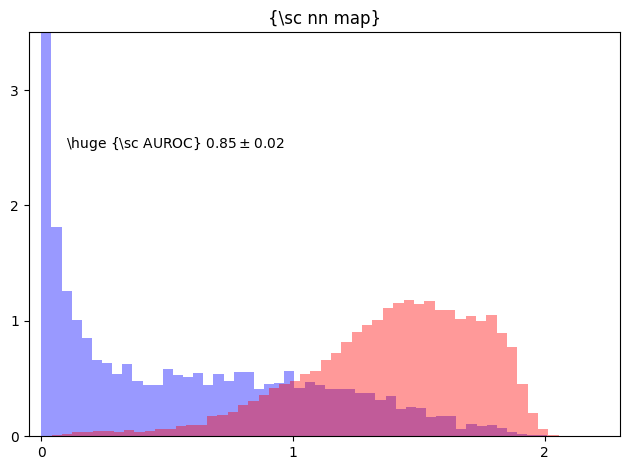

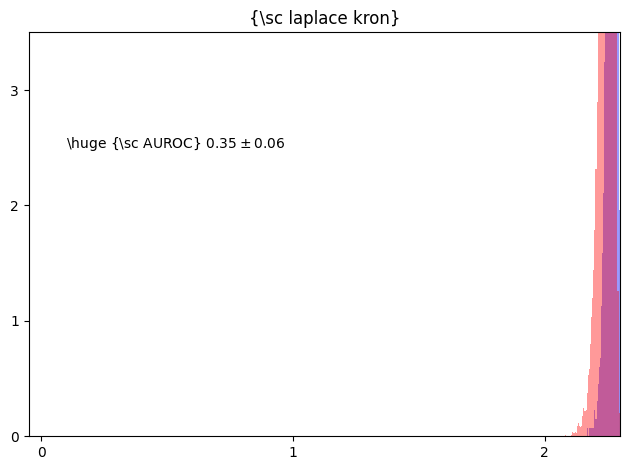

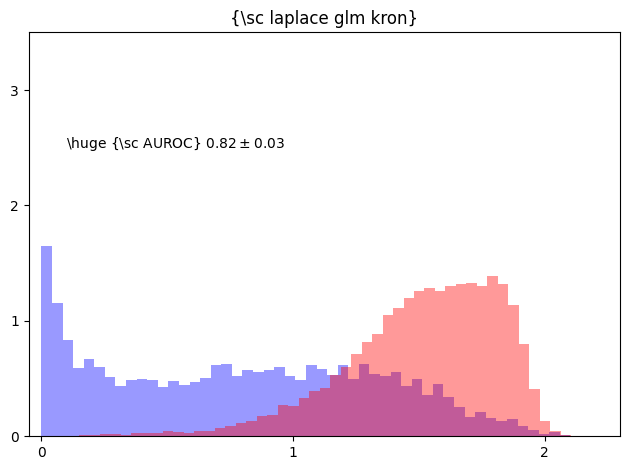

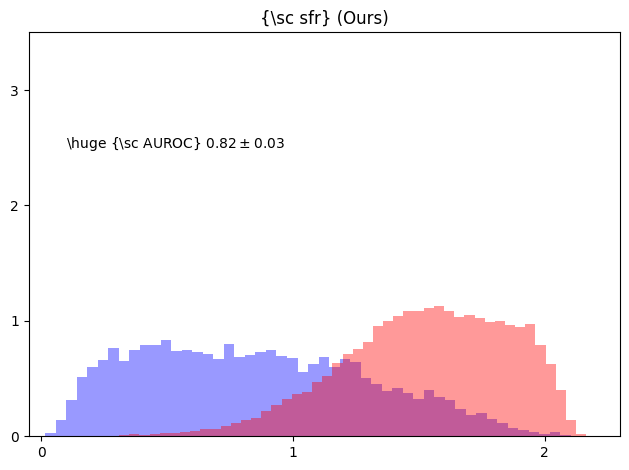

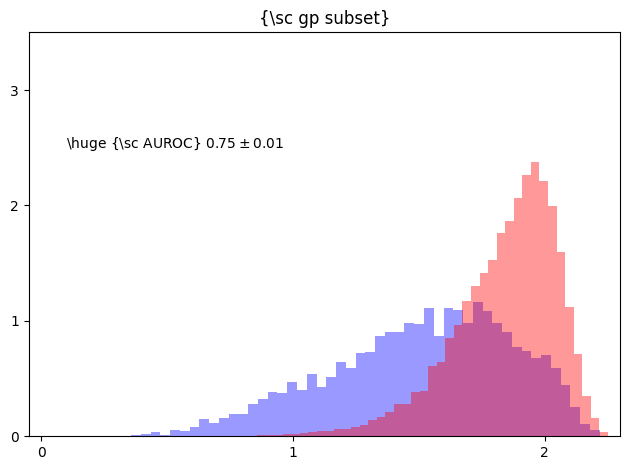

Dataset: FMNIST


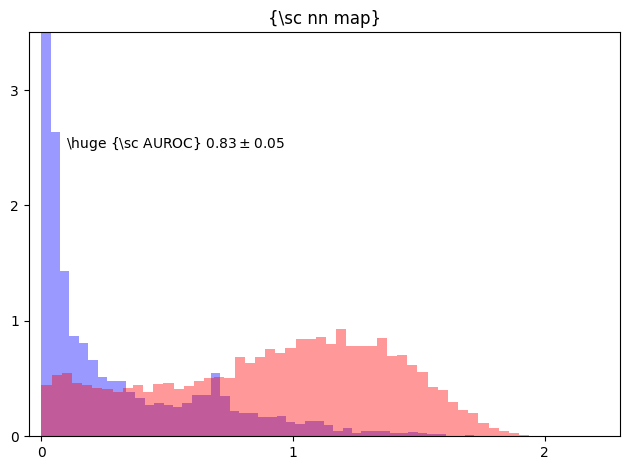

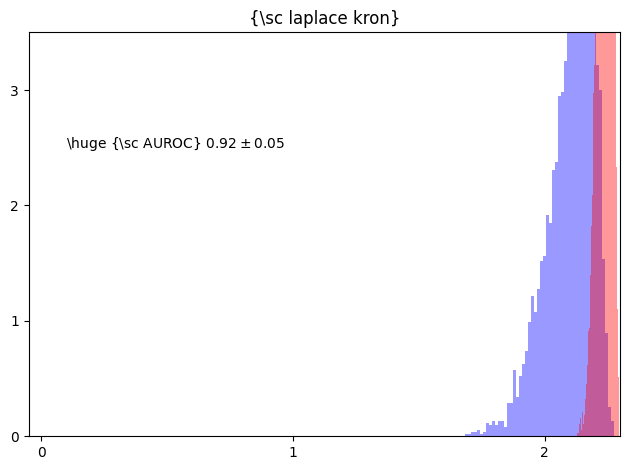

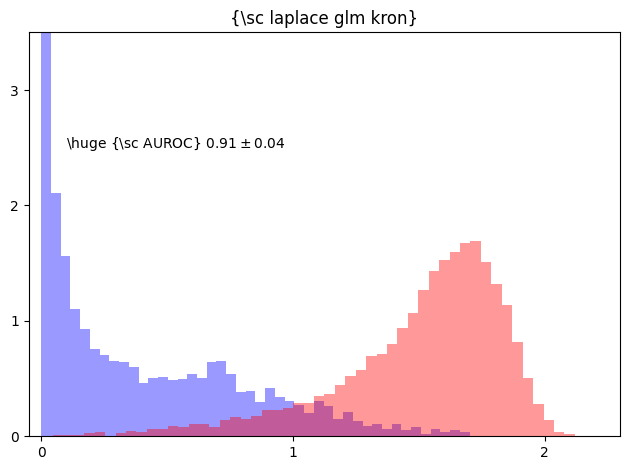

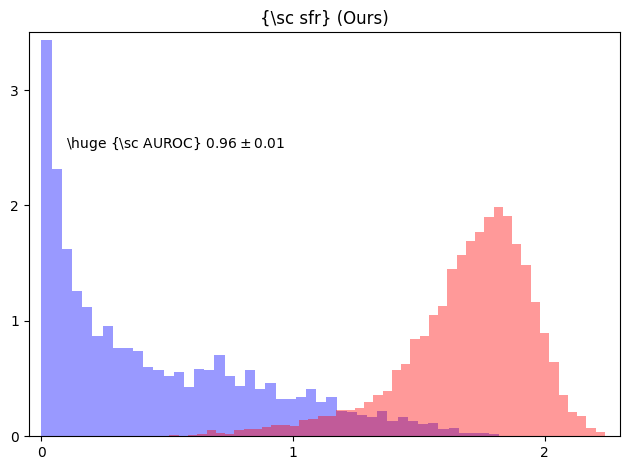

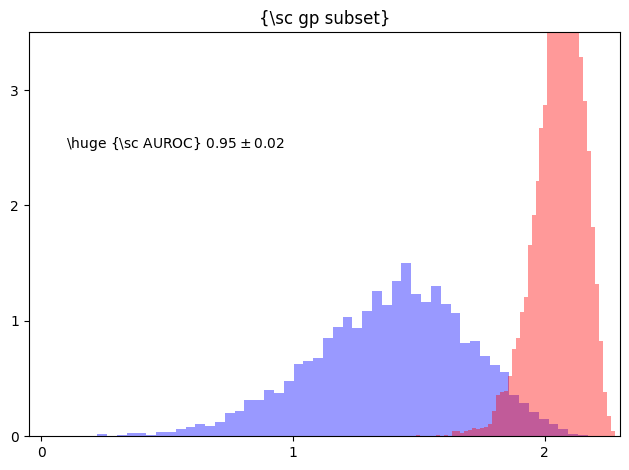

In [15]:
def plot_ood_hist(df, df_ood, N_points: int = 100000, n_bins: int = 50, alpha: float = 0.40, save: bool = False):
    MODELS = [
        "NN MAP",
        "BNN kron GRID",
        "GLM kron GRID",
        # "SFR (GP)",
        # "GP Subset (GP)",
        "SFR (GP) BO",
        "GP Subset (GP) BO",
    ]    
    FIG_TITLES = {
        "NN MAP": "{\sc nn map}",
        "BNN kron": "{\sc laplace kron}",
        "GLM kron": "{\sc laplace glm kron}",
        "BNN kron GRID": "{\sc laplace kron}",
        "GLM kron GRID": "{\sc laplace glm kron}",
        "BNN diag": "{\sc laplace diag}",
        "GLM diag": "{\sc laplace glm diag}",
        "SFR (GP)": "{\sc sfr} (Ours)",
        "GP Subset (GP)": "{\sc gp subset}",
        "SFR (GP) BO": "{\sc sfr} (Ours)",
        "GP Subset (GP) BO": "{\sc gp subset}",
    }
    SAVE_NAMES = {
        "NN MAP": "map",
        "BNN kron": "bnn_kron",
        "GLM kron": "glm_kron",
        "BNN kron GRID": "bnn_kron_tuned",
        "GLM kron GRID": "glm_kron_tuned",
        "BNN diag": "bnn_diag",
        "GLM diag": "glm_diag",
        "SFR (GP)": "sfr",
        "GP Subset (GP)": "gp_subset",
        "SFR (GP) BO": "sfr_bo",
        "GP Subset (GP) BO": "gp_subset_bo",
    }

    
     # Only keeps models we want in table
    df = df[df["model"].isin(MODELS)]
    df = df[df["num_inducing"].isin([3200, np.NaN])]
    
    # Calculate mean/std over seeds
    df = df.groupby(["dataset", "model"]).agg({'ood_auc':  ['mean', 'std', 'count']}).reset_index()
    # df_ood = df_ood.groupby(["idx", "dataset", "model"]).agg({'id':  ['mean', 'std', 'count'], 'ood': ['mean', 'std', 'count']}).reset_index()
    # Only keep the first seed for CIFAR
    # # Only keep the first seed for FMNIST
    df_ood = df_ood[df_ood["seed"].isin([0, -5])]
    
    for dataset_name in WANDB_RUNS_DICT.keys():
        print(f"Dataset: {dataset_name}")
        for model_name in MODELS:
            df_ = df[(df["model"] == model_name) & (df["dataset"] == dataset_name)]

            df_ood_ = df_ood[(df_ood["model"] == model_name) & (df_ood["dataset"] == dataset_name)]
            # return df_ood_
            ood_auc = str(round(df_["ood_auc"]["mean"].item(), 2)) + " \\pm " + str(round(df_["ood_auc"]["std"].item(), 2))
        
            fig, ax = plt.subplots(1, 1, tight_layout=True)
            
            id_values, id_bins, _ = ax.hist(
                df_ood_["id"].values, 
                # df_ood_["id"]["mean"].values, 
                density=True, 
                bins=n_bins, 
                alpha=alpha, 
                color="b"
            )
            ood_values, ood_bins, _ = ax.hist(
                df_ood_["ood"].values, 
                # df_ood_["ood"]["mean"].values, 
                density=True, 
                bins=n_bins, 
                alpha=alpha, 
                color="r"
            )
            ax.text(0.1, 2.5, '\huge {\sc AUROC} $' + ood_auc + '$')
            # ax.text(0.5, 2.5, '\huge {\sc AUROC} $' + str(round(ood_auc, 2)) + '$')
            # ax.text(2.1, 15, '\huge {\sc AUROC} $' + str(round(ood_auc, 2)) + '$')
            ax.set_title(FIG_TITLES[model_name])
            ax.set_ylim([0, 3.5])
            plt.locator_params(axis="y", nbins=4)
            plt.locator_params(axis="x", nbins=4)
            # ax.set_xlim([None, 2.3])
            ax.set_xlim([-0.05, 2.3])
            # ax.set_xlim([None, 2.1])
            if save:
                plt.savefig(f"./figs/{dataset_name}_{SAVE_NAMES[model_name]}_ood_hist.pdf")
                tikzplotlib.save(f"./figs/{dataset_name}_{SAVE_NAMES[model_name]}_ood_hist.tex", axis_width="\\figurewidth", axis_height="\\figureheight")
            plt.show()

plot_ood_hist(df, df_ood, save=True)

## Create Figure 3 - Num inducing vs NLPD figure

dataset FMNIST
num_inducings [3200. 2048. 1024.  512.  256.  128.]
num_inducings [3200. 2048. 1024.  512.  256.  128.]


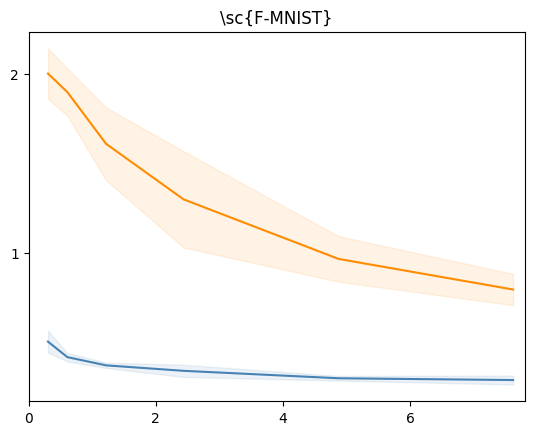

dataset CIFAR10
num_inducings [3200. 2048. 1024.  512.  256.  128.]
num_inducings [3200. 2048. 1024.  512.  256.  128.]


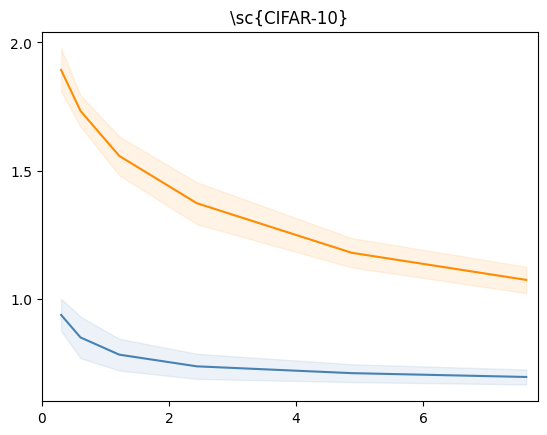

In [16]:
def plot_num_inducing_vs_nlpd(df, save: bool = False):
    MODELS = {"SFR (GP) BO": "steelblue", "GP Subset (GP) BO": "darkorange"}
    # MODELS = {"SFR (GP)": "steelblue", "GP Subset (GP)": "darkorange"}
    DATASETS = {"FMNIST": "F-MNIST", "CIFAR10": "CIFAR-10"}
    

    # Only keep models we want in table
    df_table = df[df["model"].isin(MODELS.keys())] 

    df_with_stats = df_table.groupby(["dataset", "model", "num_inducing"]).agg({'nlpd': ['mean', 'std', 'count']})
    
    for dataset in DATASETS.keys():
        print(f"dataset {dataset}")
        fig, ax = plt.subplots()
        for model_name in MODELS.keys():
            means, stds, num_inducings_percent_to_plot = [], [], []
            num_inducings = df[(df["dataset"] == dataset) & (df["model"] == model_name)].num_inducing.unique()
            print(f"num_inducings {num_inducings}")
            if num_inducings.shape[0] > 0:
                for num_inducing in num_inducings:
                    means.append(df_with_stats.loc[(dataset, model_name, num_inducing)]["nlpd"]["mean"])
                    stds.append(df_with_stats.loc[(dataset, model_name, num_inducing)]["nlpd"]["std"])
                    num_inducings_percent_to_plot.append(num_inducing)
                means = np.stack(means)
                stds = np.stack(stds)
                num_inducings_percent_to_plot = np.stack(num_inducings_percent_to_plot) / (60000*0.7) * 100
    
                ax.plot(num_inducings_percent_to_plot, means, color=MODELS[model_name], label=model_name)
                ax.fill_between(num_inducings_percent_to_plot, means - stds, means + stds,alpha=0.1, color=MODELS[model_name])
                # plt.locator_params(axis="y", nbins=4)
        ax.set_title("\sc{" + DATASETS[dataset] + "}")
        plt.locator_params(axis="y", nbins=4)
        ax.set_xlim(0, 7.8)
        plt.locator_params(axis="x", nbins=5)
        # ax.set_xlim(0.5, 5.5)
        if save:
            save_dir = "./figs"
            plt.savefig(os.path.join(save_dir, dataset + ".png"))
            tikzplotlib.save(
                os.path.join(save_dir, dataset + ".tex"),
                axis_width="\\figurewidth",
                axis_height="\\figureheight",
            )
        plt.show()

plot_num_inducing_vs_nlpd(df, save=True)